In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import glob
import os
import sys
import time
from datetime import datetime

from lsst.all_sky_phot.wcs import wcs_zea, wcs_refine_zea, Fisheye, distortion_mapper, distortion_mapper_looper, load_fisheye
from lsst.all_sky_phot import phot_night, readcr2, readYBC, radec2altaz, star2altaz, phot_image, default_phot_params
from lsst.all_sky_phot.star_catalog import read_simbad
from astropy.io import fits
from astropy import wcs
from astropy.wcs import Sip
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time, TimezoneInfo
from astropy.table import Table, vstack
from astropy import units as u

from photutils import CircularAperture, CircularAnnulus, aperture_photometry

from scipy.spatial import KDTree
import healpy as hp
from lsst.sims.utils import healbin, angularSeparation

from scipy.stats import iqr, binned_statistic
from lsst.sims.utils import healbin

In [2]:
# UT offset for Arizona
utc_offset = 7/24. # in days.

In [3]:
L3_wcs = load_fisheye('L3_wcs_w_shift.npz')

In [4]:
# load up an isolated stellar catalog
bsc = read_simbad(isolate_catalog=True, isolate_radius=20.)

In [5]:
# 
filelist = glob.glob('2018-02-05/*.fits')
filelist.extend(glob.glob('2018-01-26/*.fits'))

In [6]:
# Check the 
filters = []
for filename in filelist:
    hdul = fits.open(filename)
    filters.append(hdul[0].header['FILTERS'])
    hdul.close()

In [7]:
good = np.where(np.array(filters) == 'Filter_L3')

In [8]:
filename = filelist[good[0][0]]
hdul = fits.open(filename)
image = hdul[0].data.copy()
header = hdul[0].header.copy()
hdul.close()

In [9]:
# grab the location from the header
hdu1 = fits.open(filename)
lat = Latitude(hdu1[0].header['SITELAT'][:-3], unit=u.deg)
lon = Longitude(hdu1[0].header['SITELONG'][:-3], unit=u.deg)
elevation = 0.728  #km
PI_backyard = EarthLocation(lat=lat, lon=lon, height=elevation*u.km)
hdu1.close()

In [10]:
# need to loop over every frame and do forced photometry
# Calc where we expect stars
date_string = header['DATE-OBS']
time_obj = Time(date_string, scale='utc')
mjd = time_obj.mjd+utc_offset
alt_cat, az_cat = radec2altaz(bsc['RA'], bsc['dec'], mjd, location=PI_backyard)


In [20]:
good_cat = np.where((alt_cat > 18.1) & (bsc['Vmag'] < 7.5) & (bsc['Vmag'] > 1.))[0]
x_expected, y_expected = L3_wcs.all_world2pix(az_cat[good_cat], alt_cat[good_cat], 0.)
# clean out any random nan's
goodpix = np.where((~np.isnan(x_expected)) &(~np.isnan(y_expected)))[0]
good_cat = good_cat[goodpix]
x_expected = x_expected[goodpix]
y_expected = y_expected[goodpix]
apertures = CircularAperture( (x_expected, y_expected), r=5.)
annulus_apertures = CircularAnnulus((x_expected, y_expected), r_in=6., r_out=8.)

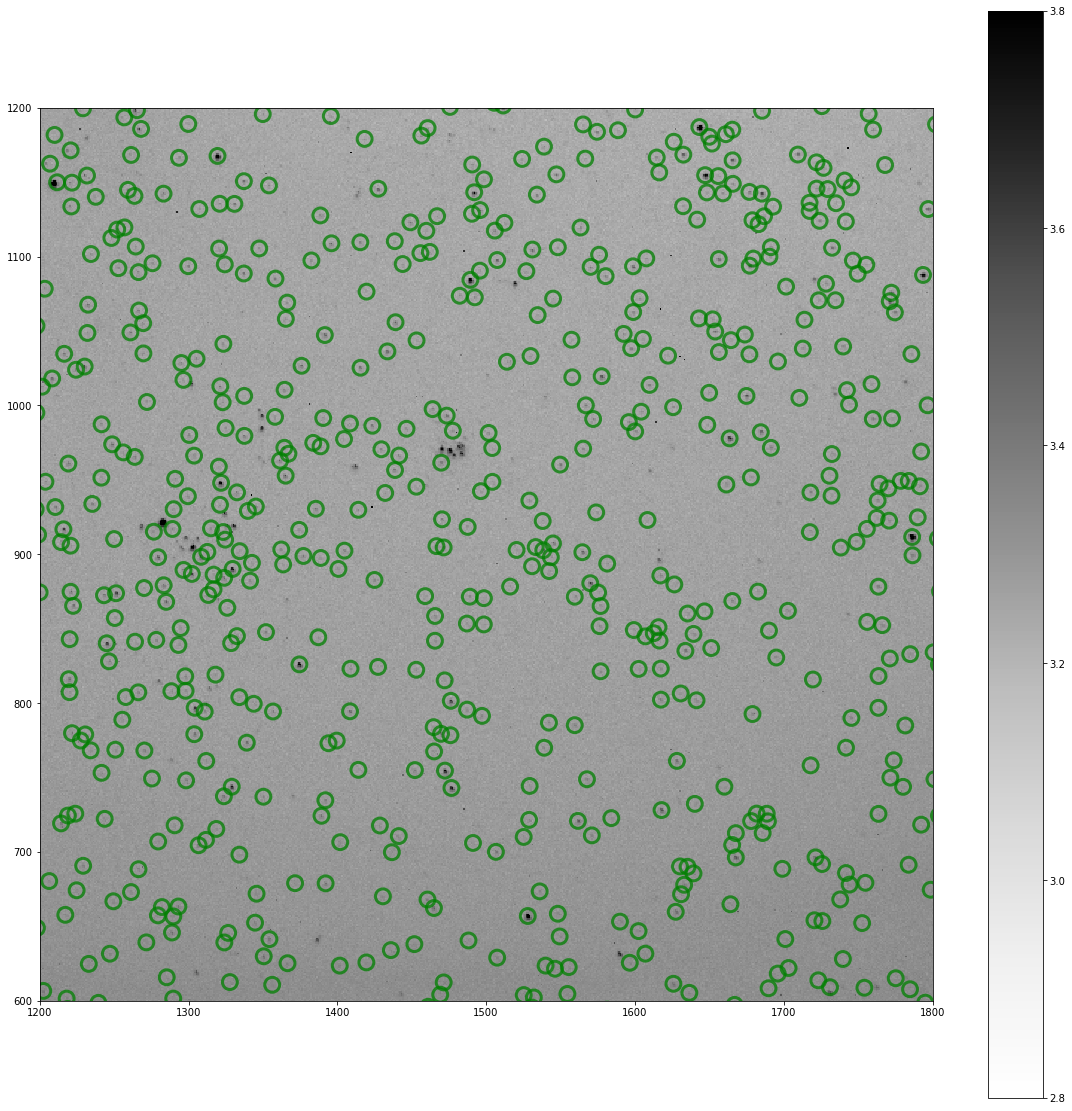

In [23]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.8)
plt.colorbar()
plt.xlim([1200, 1800])
plt.ylim([600,1200])
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

In [22]:
# replace this with a median sky subtraction
forced_table = aperture_photometry(image, [apertures, annulus_apertures])
bkg_mean = forced_table['aperture_sum_1'] / annulus_apertures.area()
bkg_sum = bkg_mean * apertures.area()
final_sum = forced_table['aperture_sum_0'] - bkg_sum
forced_table['residual_aperture_sum'] = final_sum

